# 20기 KNN 정규세션 과제

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

---

## 0. 데이터 불러오기

In [2]:
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


## 1. Preprocessing / EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


In [4]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,4.998000e+03,4998.000000,4998.000000,4998.000000,3465.000000,1544.000000,4998.000000
mean,1.003015e+06,8.036815,0.421369,5.320128,9.773737,12.766839,9234.655462
std,1.709910e+03,6.442697,0.493828,3.912281,5.101867,4.023591,4999.225081
min,1.000003e+06,0.000000,0.000000,1.000000,2.000000,3.000000,13.000000
25%,1.001560e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5497.750000
50%,1.003040e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8049.000000
75%,1.004417e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12039.000000
max,1.006037e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23913.000000


In [5]:
# Product_Category_2, Product_Category_3 결측치 비율 확인
df.isna().sum() / len(df)

User_ID                       0.000000
Product_ID                    0.000000
Gender                        0.000000
Age                           0.000000
Occupation                    0.000000
City_Category                 0.000000
Stay_In_Current_City_Years    0.000000
Marital_Status                0.000000
Product_Category_1            0.000000
Product_Category_2            0.306723
Product_Category_3            0.691076
Purchase                      0.000000
dtype: float64

In [6]:
# 같은 Product_ID를 가지는 상품 중 Product_Category_2가 결측치가 아닌 경우가 있는지 확인
df[df["Product_ID"].isin(df[df["Product_Category_2"].isna()]["Product_ID"].unique()) & df["Product_Category_2"].notna()].sort_values("Product_ID")

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase


In [7]:
# 같은 Product_ID를 가지는 상품 중 Product_Category_3가 결측치가 아닌 경우가 있는지 확인
df[df["Product_ID"].isin(df[df["Product_Category_3"].isna()]["Product_ID"].unique()) & df["Product_Category_3"].notna()].sort_values("Product_ID")

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase


In [8]:
df[["Product_Category_1", "Product_Category_2", "Product_Category_3"]].sort_values(["Product_Category_1", "Product_Category_2"])

,Product_Category_1,Product_Category_2,Product_Category_3
22,1,2.0,NaN
65,1,2.0,16.0
77,1,2.0,5.0
85,1,2.0,5.0
113,1,2.0,14.0
...,...,...,...
4821,20,NaN,NaN
4827,20,NaN,NaN
4870,20,NaN,NaN
4944,20,NaN,NaN


`Product_Category_2`, `Product_Category_3`는 `Product_Category`라는 prefix를 공유하는 feature와 독립적이지 않을 수 있습니다. \
별도의 category를 추가하여 결측치를 채웁니다.

In [9]:
print(sorted(df["Product_Category_2"].unique()))
print(sorted(df["Product_Category_3"].unique()))

[17.0, nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0]
[nan, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]


In [10]:
df.fillna(value=0, downcast="infer", inplace=True)

<Axes: ylabel='Gender'>

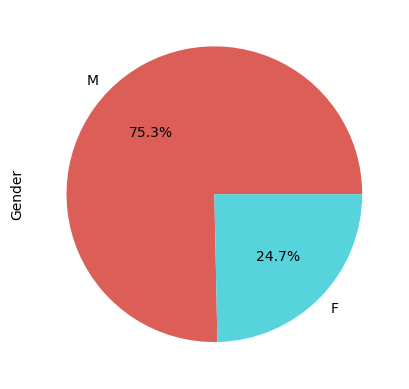

In [11]:
# Gender 비율 확인하기
df["Gender"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("hls", 2))

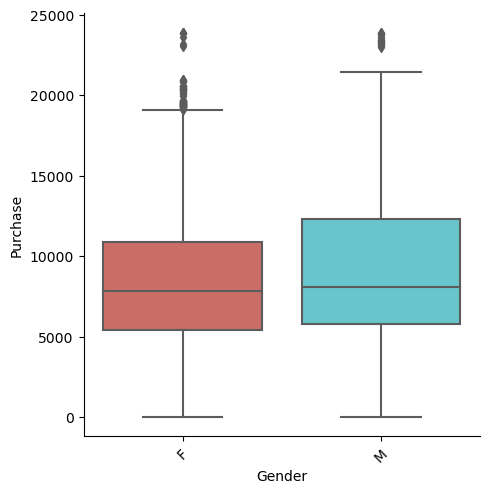

In [12]:
# Gender와 Purchase 관계 살펴보기
sns.catplot(df, x="Gender", y="Purchase", kind="box", palette="hls")
plt.xticks(rotation=45)
plt.show()

<Axes: ylabel='Age'>

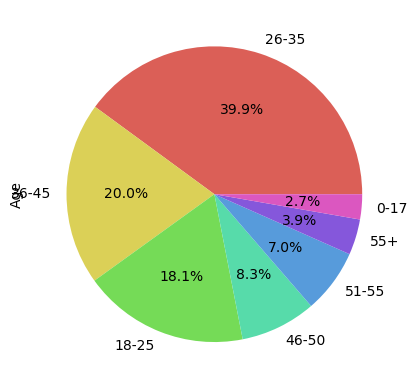

In [13]:
# Age 비율 확인하기
df["Age"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("hls", 7))

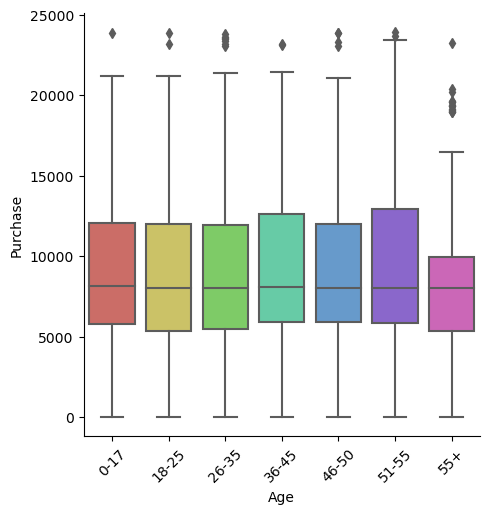

In [14]:
# Age와 Purchase 관계 살펴보기
sns.catplot(df, x="Age", y="Purchase", kind="box", palette="hls")
plt.xticks(rotation=45)
plt.show()

<Axes: ylabel='Occupation'>

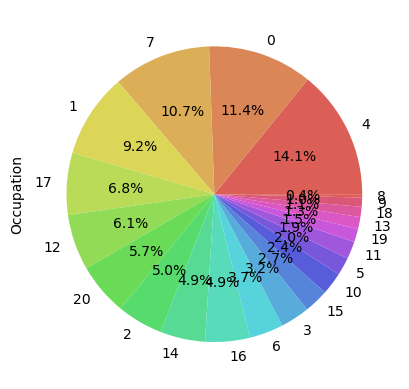

In [15]:
# Occupation 비율 확인하기
df["Occupation"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("hls", 20))

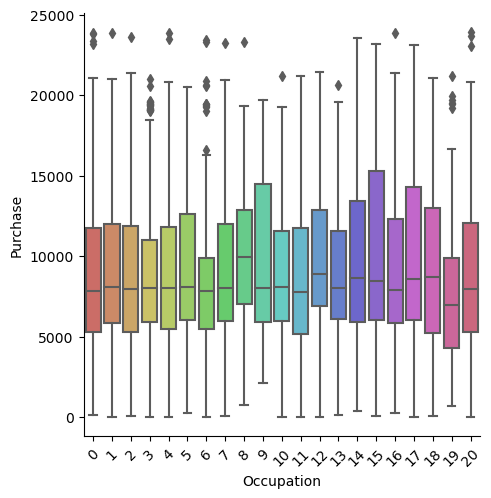

In [16]:
# Occupation와 Purchase 관계 살펴보기
sns.catplot(df, x="Occupation", y="Purchase", kind="box", palette="hls")
plt.xticks(rotation=45)
plt.show()

<Axes: ylabel='City_Category'>

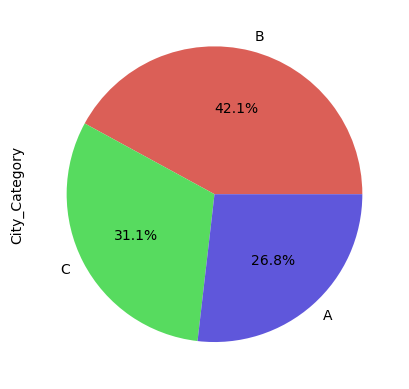

In [17]:
# City_Category 비율 확인하기
df["City_Category"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("hls", 3))

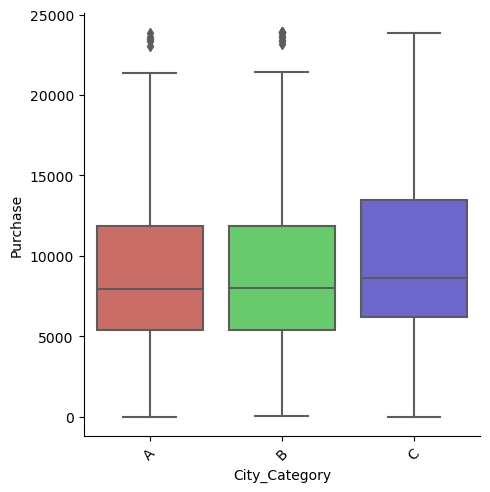

In [18]:
# City_Category와 Purchase 관계 살펴보기
sns.catplot(df, x="City_Category", y="Purchase", kind="box", palette="hls")
plt.xticks(rotation=45)
plt.show()

<Axes: ylabel='Stay_In_Current_City_Years'>

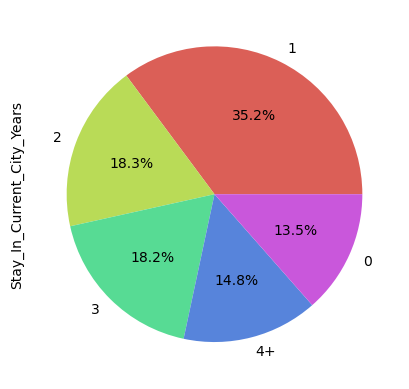

In [19]:
# Stay_In_Current_City_Years 비율 확인하기
df["Stay_In_Current_City_Years"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("hls", 5))

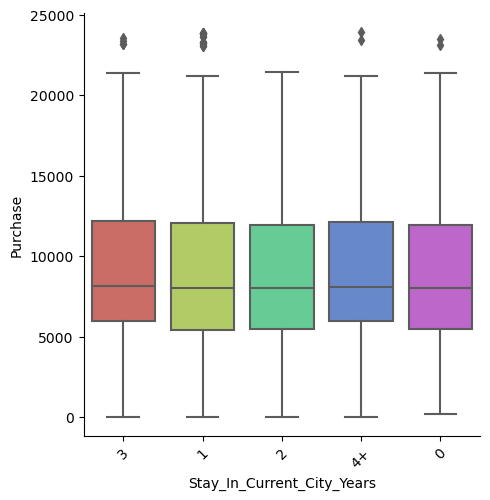

In [20]:
# Stay_In_Current_City_Years와 Purchase 관계 살펴보기
sns.catplot(df, x="Stay_In_Current_City_Years", y="Purchase", kind="box", palette="hls")
plt.xticks(rotation=45)
plt.show()

<Axes: ylabel='Marital_Status'>

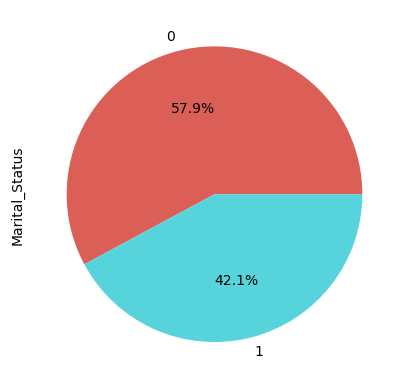

In [21]:
# Marital_Status 비율 확인하기
df["Marital_Status"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("hls", 2))

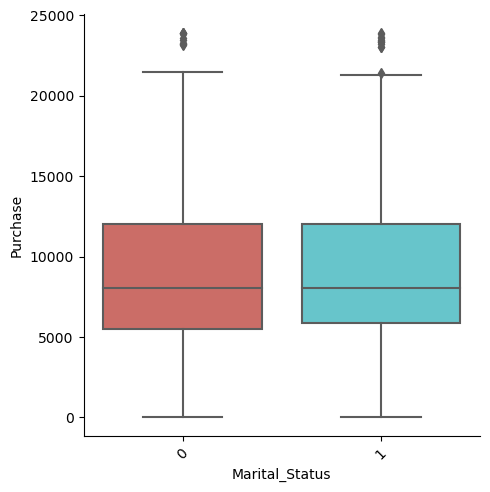

In [22]:
# Marital_Status와 Purchase 관계 살펴보기
sns.catplot(df, x="Marital_Status", y="Purchase", kind="box", palette="hls")
plt.xticks(rotation=45)
plt.show()

<Axes: ylabel='Product_Category_1'>

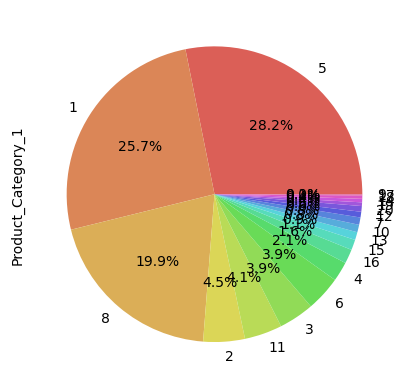

In [23]:
# Product_Category_1 비율 확인하기
df["Product_Category_1"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("hls", 20))

- `Gender`
- `Age`
- `Occupation`
- `Product_Category_1`

의 경우 비교적 불균형함을 알 수 있습니다.

`Gender`, `Age`, `City_Category`, `Stay_In_Current_City_Years`를 수치화합니다.

- `Gender`: 이진변수이므로, 0 또는 1로 label encoding
- `Age`: 순서가 존재하므로 label encoding
- `City_Category`: 도시간 순서 및 관계를 확인할 수 없으나, `Product_Category_1` 등의 categorial variables와 동일하게 label encoding
- `Stay_In_Current_City_Years`: 순서가 존재하므로 label encoding

을 수행합니다.

In [24]:
df["Gender"].replace({"M": 0, "F": 1}, inplace=True)
df["Age"].replace({"0-17": 0, "18-25": 1, "26-35": 2, "36-45": 3, "46-50": 4, "51-55": 5, "55+": 6}, inplace=True)
df["City_Category"].replace({"A": 0, "B": 1, "C": 2}, inplace=True)
df["Stay_In_Current_City_Years"].replace({"0": 0, "1": 1, "2": 2, "3": 3, "4+": 4}, inplace=True)

## 2. KNN 구현 & 파라미터 튜닝

<Axes: xlabel='Purchase', ylabel='Count'>

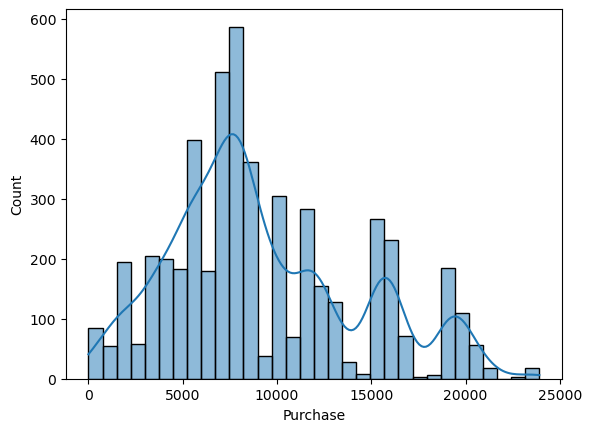

In [25]:
# Purchase 분포 확인하기
sns.histplot(df["Purchase"], kde=True)

In [26]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [27]:
train_x = train_df.drop(columns=["User_ID", "Product_ID"])
train_y = train_df["Purchase"]
test_x = test_df.drop(columns=["User_ID", "Product_ID"])
test_y = test_df["Purchase"]

In [28]:
metrics = {
    "MAE": mean_absolute_error,
    "MSE": mean_squared_error,
    "R-squared": r2_score,
}

In [29]:
# K 튜닝
regressors_with_k = [
    KNeighborsRegressor(n_neighbors=3, metric="minkowski"),
    KNeighborsRegressor(n_neighbors=5, metric="minkowski"),
    KNeighborsRegressor(n_neighbors=7, metric="minkowski"),
    KNeighborsRegressor(n_neighbors=9, metric="minkowski"),
    KNeighborsRegressor(n_neighbors=11, metric="minkowski")
]

In [30]:
for regressor in regressors_with_k:
    regressor.fit(train_x, train_y)
    pred_y = regressor.predict(train_x)
    for key, metric in metrics.items():
        print(f"regressor with {regressor.n_neighbors} neighbors - {key}: {metric(train_y, pred_y)}")

regressor with 3 neighbors - MAE: 2.767467066866776
regressor with 3 neighbors - MSE: 30.91520760380188
regressor with 3 neighbors - R-squared: 0.9999987689656348
regressor with 5 neighbors - MAE: 3.44342171085544
regressor with 5 neighbors - MSE: 77.55097548774407
regressor with 5 neighbors - R-squared: 0.9999969119432384
regressor with 7 neighbors - MAE: 3.9564067748159717
regressor with 7 neighbors - MSE: 122.09284233953726
regressor with 7 neighbors - R-squared: 0.9999951382993577
regressor with 9 neighbors - MAE: 4.681007170251809
regressor with 9 neighbors - MSE: 206.98107078230527
regressor with 9 neighbors - R-squared: 0.9999917580753672
regressor with 11 neighbors - MAE: 5.530310609850377
regressor with 11 neighbors - MSE: 341.60812637723797
regressor with 11 neighbors - R-squared: 0.9999863972660838


## 3. Evaluation

In [31]:
for regressor in regressors_with_k:
    pred_y = regressor.predict(test_x)
    for key, metric in metrics.items():
        print(f"regressor with {regressor.n_neighbors} neighbors - {key}: {metric(test_y, pred_y)}")

regressor with 3 neighbors - MAE: 4.358666666666639
regressor with 3 neighbors - MSE: 99.88244444444379
regressor with 3 neighbors - R-squared: 0.9999959200385748
regressor with 5 neighbors - MAE: 4.392199999999999
regressor with 5 neighbors - MSE: 143.04756000000057
regressor with 5 neighbors - R-squared: 0.9999941568457799
regressor with 7 neighbors - MAE: 4.5921428571428295
regressor with 7 neighbors - MSE: 191.0500612244903
regressor with 7 neighbors - R-squared: 0.999992196057231
regressor with 9 neighbors - MAE: 5.021444444444444
regressor with 9 neighbors - MSE: 265.82729629629677
regressor with 9 neighbors - R-squared: 0.9999891415841824
regressor with 11 neighbors - MAE: 5.659454545454537
regressor with 11 neighbors - MSE: 366.58057851239687
regressor with 11 neighbors - R-squared: 0.9999850260510956
